In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import DBSCAN
import matplotlib.patches as patches


### Defining Parameters

In [2]:
# World → image1
image_width = 1280
image_height = 720


# Scan 0
x0, y0 = 0, 7500
h0 = 2500
theta0 = 45 # yaw
phi0 = 50   # pitch
hfov0 = 17.5   # horizontal field of view

# Define standard deviations (σ) for each parameter
x_std = 2
y_std = 2
h_std = 2
theta_std = 1
phi_std = 0.2
hfov_std = 0.1

# Fire Max Size (length)
fire_size = 10 # [m]

# DB_Scan parameters
min_samples_factor = 10
eps_distance_factor = 1.5

# FOV calc for Phase 2
patch_length = 224  # total patch size in pixels
ratio_patch = 0.7         # fire ratio within the patch
ratio_image = 0.25         # fire ratio within the RGB image
IR2RGB_ratio = 1920 / 1280  # resolution ratio between RGB and IR images
rgb_len = 1080
min_fov = 2.2   # degrees - minimal allowed FOV
max_fov = 60.0  # degrees - maximal allowed FOV

In [3]:
# Generate Scan 1 values using Gaussian distribution (mean=0)
x1 = x0 + random.gauss(0, x_std)
y1 = y0 + random.gauss(0, y_std)
h1 = h0 + random.gauss(0, h_std)
theta1 = theta0 + random.gauss(0, theta_std)
phi1 = phi0 + random.gauss(0, phi_std)
hfov1 = hfov0 + random.gauss(0, hfov_std)


# Important Calculation
# Calculations
Slant_Range = h1 * 0.001 / np.cos(np.deg2rad(phi1))  # Slant range from camera to ground (meters)
HFOV = hfov1  # Horizontal field of view (degrees)
IFOV = HFOV / 1920 / 180 * np.pi * 1_000_000  # Instantaneous Field of View [urad]
GSD = Slant_Range * IFOV / 1000  # Ground Sampling Distance [meters per pixel]

fire_length_pixel = np.floor(fire_size / GSD)
fire_num_pixel = fire_length_pixel**2

## Functions

In [4]:
# Functions

def project_points_with_homography(corners, H):
    # Convert input 2D corner points to homogeneous coordinates by appending a column of ones.
    # corners: array of shape (N, 2), where N is the number of points.
    # corners_h: array of shape (N, 3)
    ones = np.ones((corners.shape[0], 1))
    corners_h = np.hstack([corners, ones])  # Shape: (N, 3)

    # Apply the homography transformation matrix H to the homogeneous coordinates.
    # H is a 3x3 matrix, and the result is a set of projected homogeneous coordinates.
    projected_h = (H @ corners_h.T).T  # Shape: (N, 3)

    # Convert back from homogeneous to 2D pixel coordinates by dividing x and y by the scale (z).
    projected_pixels = projected_h[:, :2] / projected_h[:, 2, np.newaxis]

    # Return the projected 2D pixel coordinates as a (N, 2) array.
    return projected_pixels



# === 1. Create homography matrix ===
def create_homography(pts_dst, pts_src):
    """
    Computes the homography matrix that maps points from the source image to the destination image.

    Parameters:
        pts_dst (ndarray): Coordinates in the destination image (Nx2 array).
        pts_src (ndarray): Corresponding coordinates in the source image (Nx2 array).

    Returns:
        H (ndarray): 3x3 homography matrix that satisfies pts_dst ≈ H * pts_src.
    """
    # Use OpenCV's findHomography to compute the best-fitting homography matrix
    # that maps pts_src to pts_dst. It uses RANSAC by default to improve robustness.
    H, _ = cv2.findHomography(pts_src, pts_dst)

    # Return the resulting homography matrix
    return H

# === 2. Convert grid index (i, j) to image coordinates (u, v) ===
def grid_to_image(i, j, H_grid_to_world, H_world_to_image):
    """
    Converts a grid cell index (i, j) into its corresponding image coordinates (u, v),
    using two homography transformations:
        - H_grid_to_world: maps grid indices to world coordinates.
        - H_world_to_image: maps world coordinates to image (pixel) coordinates.

    Parameters:
        i (int): Grid row index.
        j (int): Grid column index.
        H_grid_to_world (ndarray): 3x3 homography from grid to world coordinates.
        H_world_to_image (ndarray): 3x3 homography from world to image coordinates.

    Returns:
        u (float): Horizontal image coordinate.
        v (float): Vertical image coordinate.
    """
    # Convert grid indices (i, j) into a homogeneous point [x=j, y=i, 1]
    point_grid = np.array([j, i, 1.0], dtype=np.uint8)

    # Transform to world coordinates using the grid-to-world homography
    point_world = H_grid_to_world @ point_grid
    point_world /= point_world[2]  # Normalize to get Cartesian coordinates
    lon, lat = point_world[0], point_world[1]  # Extract world coordinates

    # Convert world coordinates back into homogeneous form
    point_world_hom = np.array([lon, lat, 1.0], dtype=np.uint8)

    # Transform to image coordinates using the world-to-image homography
    point_image = H_world_to_image @ point_world_hom
    point_image /= point_image[2]  # Normalize

    # Extract pixel coordinates (u, v)
    u, v = point_image[0], point_image[1]

    return u, v


# === 4. Compute difference ===
def compute_difference_map(original, updated):
    """
    Computes the difference map between two images or grids by simple subtraction.

    Parameters:
        original (ndarray): Original image or data map.
        updated (ndarray): Updated image or data map.

    Returns:
        difference (ndarray): Element-wise difference (updated - original).
    """
    return updated - original


def preprocess_images(image1, image2, applying=0):
    """
    Preprocesses two input images by converting them to uint8 format,
    and optionally normalizing them by subtracting their mean.

    Parameters:
        image1 (ndarray): First input image.
        image2 (ndarray): Second input image.
        applying (int): If greater than 0, subtract the mean from each image (zero-mean normalization).

    Returns:
        img1 (ndarray): Preprocessed version of image1.
        img2 (ndarray): Preprocessed version of image2.
    """
    # Convert images to unsigned 8-bit integers
    img1 = image1.astype(np.uint8)
    img2 = image2.astype(np.uint8)

    # Optionally normalize by subtracting the mean (if applying > 0)
    if applying > 0:
        img1 = img1 - img1.mean()
        img2 = img2 - img2.mean()

    return img1, img2

def compute_positive_difference(img1, img2):
    """
    Computes the positive difference between two images by subtracting img1 from img2,
    and setting all negative results to zero.

    Parameters:
        img1 (ndarray): First input image or matrix.
        img2 (ndarray): Second input image or matrix.

    Returns:
        diff (ndarray): Element-wise difference (img2 - img1), with negative values clipped to zero.
    """
    # Subtract img1 from img2 to get the difference
    diff = img2 - img1


    # Optional: Handle NaN values (commented out)
    # diff[np.isnan(diff)] = 0

    # Clip all negative values to zero
    diff[diff < 0] = 0
    
    return diff

def postprocess_difference_map(diff, img2, threshold=None, temp_threshold=None):
    """
    Post-processes the difference map by removing (zeroing out) pixels that do not meet certain criteria.

    Parameters:
        diff (ndarray): The computed difference map (same dimensions as img2).
        img2 (ndarray): Reference image used for intensity-based filtering.
        threshold (float or None): Minimum allowed value in `diff`. Values below or equal to this are zeroed.
        temp_threshold (float or None): Additional filtering based on pixel intensity in `img2`.
                                        Pixels with intensity less than (mean + temp_threshold) are zeroed.

    Returns:
        diff (ndarray): The processed difference map after applying the filters.
    """
    # Zero out pixels in the difference map that are below or equal to the fixed threshold
    if threshold is not None:
        diff[diff <= threshold] = 0

    # Zero out pixels where the corresponding value in img2 is below (mean + temp_threshold)
    if temp_threshold is not None:
        temp_mask = img2 <= (img2.mean() + temp_threshold)
        diff[temp_mask] = 0

    return diff



def find_cluster_centers_conditional(diff_map, threshold=10, eps=1.5, min_samples=2, min_contrast=10):
    """
    Applies DBSCAN clustering to a difference map and returns:
    - cluster centers (either hottest point or geometric center, based on contrast),
    - bounding boxes for each cluster,
    - a label map marking cluster membership for each pixel.

    Parameters:
        diff_map (ndarray): 2D difference map.
        threshold (float): Minimum pixel value to be considered for clustering.
        eps (float): Maximum distance between two samples for them to be considered in the same neighborhood (DBSCAN).
        min_samples (int): Minimum number of points required to form a cluster (DBSCAN).
        min_contrast (float): Minimum contrast needed to select the "hottest" pixel as center. Otherwise, geometric center is used.

    Returns:
        centers (list of tuple): List of cluster centers, each as (i, j). Can be float if using mean.
        label_map (ndarray): 2D array with same shape as `diff_map`, containing cluster labels.
        bboxes (list of tuple): Bounding box per cluster, each as (min_i, min_j, max_i, max_j).
    """
    # Extract pixels above the given threshold
    active_pixels = np.argwhere(diff_map > threshold)
    if len(active_pixels) == 0:
        # If no active pixels, return empty results and label map filled with -1 (no labels)
        return [], [], np.full_like(diff_map, -1)

    # Apply DBSCAN clustering on the coordinates of active pixels
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(active_pixels)
    labels_flat = clustering.labels_

    # Create a label map initialized with -1 (unlabeled/noise)    
    label_map = np.full(diff_map.shape, -1, dtype=int)
    for idx, (i, j) in enumerate(active_pixels):
        label_map[i, j] = labels_flat[idx]

    centers = []
    bboxes = []
    
    # Iterate over unique cluster labels (excluding noise label -1)
    for label in np.unique(labels_flat):
        if label == -1:
            continue  # skip noise points

        # Extract points and corresponding diff values for the current cluster
        cluster_points = active_pixels[labels_flat == label]
        values = diff_map[cluster_points[:, 0], cluster_points[:, 1]]

        # Decide center point:
        # If the cluster has enough contrast, pick the hottest pixel (max value)
        # Otherwise, use the geometric center (mean of coordinates)
        contrast = values.max() - 2 * values.mean()
        if contrast >= min_contrast:
            hottest_idx = np.argmax(values)
            center = cluster_points[hottest_idx]
        else:
            center = cluster_points.mean(axis=0)

        centers.append(tuple(center))

        # Calculate bounding box: (min_i, min_j, max_i, max_j)
        min_i, min_j = cluster_points.min(axis=0)
        max_i, max_j = cluster_points.max(axis=0)
        bboxes.append((min_i, min_j, max_i, max_j))

    return centers, label_map, bboxes

## Simulation Functions

In [5]:
def create_synthetic_image_with_clusters(image_height, image_width,
                                         background_range=(3, 7),
                                         cluster_value=200,
                                         num_clusters_range=(1, 4),
                                         cluster_radius_range=(1, 9)):
    """
    Creates a synthetic grayscale image with a random uniform background and several bright Gaussian clusters.

    Parameters:
        image_height (int): Height of the generated image.
        image_width (int): Width of the generated image.
        background_range (tuple): Range (min, max) for background pixel values (uniformly sampled).
        cluster_value (int or float): Maximum intensity value at the center of each Gaussian cluster.
        num_clusters_range (tuple): Range (min, max) for the number of clusters to generate (inclusive).
        cluster_radius_range (tuple): Range (min, max) for Gaussian cluster radius (in pixels, inclusive).

    Returns:
        image (ndarray): A 2D numpy array (uint8) representing the synthetic image.
    """
    # 1. Generate the background with uniform random values in the given range
    
    image = np.random.uniform(*background_range, size=(image_height, image_width)).astype(np.uint8)

    # 2. Randomly determine how many clusters to add
    num_clusters = np.random.randint(num_clusters_range[0], num_clusters_range[1] + 1)

    for _ in range(num_clusters):
        # 3. Randomly select cluster center coordinates (cx, cy)
        cx = np.random.randint(0, image_width)
        cy = np.random.randint(0, image_height)

        # 4. Randomly choose a radius for the Gaussian cluster
        radius = np.random.randint(cluster_radius_range[0], cluster_radius_range[1] + 1)

        # 5. Create a 2D Gaussian blob centered at (cx, cy)
        y, x = np.meshgrid(np.arange(image_height), np.arange(image_width), indexing='ij')
        dist_sq = (x - cx) ** 2 + (y - cy) ** 2
        gaussian_blob = cluster_value * np.exp(-dist_sq / (2 * (radius ** 2)))

        # 6. Add the Gaussian cluster to the image, taking max to preserve brighter intensities
        image = np.maximum(image, gaussian_blob)

    return image



def add_uniform_spots(image,
                      value_range=(95, 105),
                      spot_radius_range=(10, 30),
                      num_spots_range=(1, 4)):
    """
    Adds circular uniform-noise patches (spots) to a given grayscale image.

    Parameters:
        image (ndarray): 2D numpy array representing the image. This array is modified in-place.
        value_range (tuple): Range (min, max) for pixel values inside each spot, sampled uniformly.
        spot_radius_range (tuple): Range (min, max) for the radius of each circular spot.
        num_spots_range (tuple): Range (min, max) for the number of spots to add (inclusive).

    Returns:
        None (the input image is modified directly).
    """
    height, width = image.shape

    # Randomly determine how many spots to add
    num_spots = np.random.randint(*num_spots_range)

    for _ in range(num_spots):
        # Randomly select center coordinates for the spot
        cx = np.random.randint(0, width)
        cy = np.random.randint(0, height)

        # Randomly select spot radius
        radius = np.random.randint(*spot_radius_range)

        # Create a circular binary mask centered at (cx, cy)
        y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
        dist_sq = (x - cx) ** 2 + (y - cy) ** 2
        mask = dist_sq <= radius ** 2

        # Generate a patch of random uniform values in the given range
        patch = np.random.uniform(*value_range, size=image.shape)
        
        # Apply the patch inside the circular region (mask)        
        image[mask] = patch[mask]


def compute_vfov_from_hfov(hfov_deg, width, height):
    """
    Computes the vertical field of view (vFOV) in degrees, given the horizontal field of view (hFOV)
    and the image's width and height.

    Parameters:
        hfov_deg (float): Horizontal field of view in degrees.
        width (int): Image width in pixels.
        height (int): Image height in pixels.

    Returns:
        vfov_deg (float): Vertical field of view in degrees.
    """
    # Convert horizontal FOV from degrees to radians
    hfov_rad = np.radians(hfov_deg)
    
    # Compute aspect ratio (height divided by width)    
    aspect_ratio = height / width

    # Use trigonometric identity to calculate vertical FOV in radians
    vfov_rad = 2 * np.arctan(np.tan(hfov_rad / 2) * aspect_ratio)

    # Convert vertical FOV back to degrees
    return np.degrees(vfov_rad)

def get_ground_corners(x, y, h, theta_deg, phi_deg, hfov_deg, width=1280, height=720):
    """
    Computes the 4 ground-intersection points (in world coordinates) of the camera's image corners,
    based on camera pose and field of view.

    Parameters:
        x (float): Camera X position in world coordinates.
        y (float): Camera Y position in world coordinates.
        h (float): Camera height (Z position) above the ground.
        theta_deg (float): Yaw angle in degrees (rotation around Z-axis).
        phi_deg (float): Pitch angle in degrees (rotation around X-axis).
        hfov_deg (float): Horizontal field of view in degrees.
        width (int): Image width in pixels (default: 1280).
        height (int): Image height in pixels (default: 720).

    Returns:
        corners_world (ndarray): Array of shape (4, 2) with (X, Y) coordinates of the ground-intersection
                                 points for each image corner (in clockwise order).
    """
    # Step 1: Compute vertical FOV based on image dimensions and horizontal FOV
    vfov_deg = compute_vfov_from_hfov(hfov_deg, width, height)

    # Convert angles from degrees to radians
    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)
    hfov = np.radians(hfov_deg)
    vfov = np.radians(vfov_deg)
    
    # Step 2: Define direction vectors (in camera frame) for image corners in normalized coordinates
    # Each corner vector points toward a corner of the image plane in 3D space
    corners = np.array([
        [np.tan(hfov/2),  np.tan(vfov/2), -1],
        [-np.tan(hfov/2),  np.tan(vfov/2), -1],
        [-np.tan(hfov/2), -np.tan(vfov/2), -1],
        [np.tan(hfov/2), -np.tan(vfov/2), -1],
    ])

    # Normalize direction vectors
    dirs = corners / np.linalg.norm(corners, axis=1, keepdims=True)

    # Step 3: Define rotation matrices for yaw (Z-axis) and pitch (X-axis)
    R_yaw = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])

    R_pitch = np.array([
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi),  np.cos(phi)]
    ])

    # Combine rotations: first apply pitch, then yaw
    R = R_yaw @ R_pitch

    # Step 4: Transform direction vectors to world coordinates
    world_dirs = dirs @ R.T

    # Step 5: Compute intersection of each direction ray with the ground plane (Z=0)
    corners_world = []
    for d in world_dirs:
        scale = -h / d[2]  # Solve for when Z = 0 (ground)
        point = np.array([x, y, h]) + scale * d  # Ray origin + scaled direction
        corners_world.append(point[:2])  # Keep only (X, Y) coordinates
        
    return np.array(corners_world)

    
def compute_polygon_area(points):
    """
    Computes the area of a 2D polygon using the Shoelace formula.

    Parameters:
        points (ndarray): Array of shape (N, 2), representing the polygon's vertices
                          in order (either clockwise or counter-clockwise).

    Returns:
        area (float): The absolute area of the polygon.
    """
    # Extract x and y coordinates of the points
    x = points[:, 0]
    y = points[:, 1]

    # Apply the Shoelace formula:
    # Area = 0.5 * |sum(x_i * y_{i+1} - y_i * x_{i+1})|
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def plot_drone_view(corners1, corners2, drone_pos, range_xy=15000):
    """
    Plots two camera footprints (projected ground corners) from a drone's perspective,
    along with the drone's position.

    Parameters:
        corners1 (ndarray): (4, 2) array representing the first camera's ground footprint corners.
        corners2 (ndarray): (4, 2) array representing the second camera's ground footprint corners.
        drone_pos (tuple): (x, y) coordinates of the drone in world space.
        range_xy (float): Axis range for X and Y (plot limits centered at origin).

    Returns:
        None (displays a matplotlib plot).
    """
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the drone's position as a red dot
    ax.plot(*drone_pos, 'ro', label='Drone Position')

    # Plot first camera footprint polygon
    polygon1 = np.vstack([corners1, corners1[0]])  # Close the polygon
    ax.plot(polygon1[:, 0], polygon1[:, 1], 'b-', label='Camera Footprint 1')
    ax.fill(polygon1[:, 0], polygon1[:, 1], color='lightblue', alpha=0.4)

    # Plot second camera footprint polygon
    polygon2 = np.vstack([corners2, corners2[0]])  # Close the polygon
    ax.plot(polygon2[:, 0], polygon2[:, 1], 'g-', label='Camera Footprint 2')
    ax.fill(polygon2[:, 0], polygon2[:, 1], color='lightgreen', alpha=0.4)

    # Set axis limits centered at origin
    ax.set_xlim(-range_xy, range_xy)
    ax.set_ylim(-range_xy, range_xy)

    # Make the plot square and readable
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Drone Camera Ground Footprints")

    # Show the plot
    plt.show()



def simulate_zoom(image, center, fov_ratio, IR2RGB_ratio=IR2RGB_ratio):
    """
    Simulates a digital zoom-in effect by cropping the image around a given center point
    and resizing it back to the original dimensions. Optionally adjusts the center point
    using a scaling factor (e.g., to align between IR and RGB resolutions).

    Parameters:
        image (ndarray): Input image (assumed grayscale or single-channel).
        center (tuple): (y, x) coordinates of the zoom center in the original image (before scaling).
        fov_ratio (float): Fraction of the field of view to retain (e.g., 0.5 crops to 50% of width/height).
        IR2RGB_ratio (float): Ratio to scale the center coordinates (e.g., IR resolution to RGB alignment).

    Returns:
        cropped (ndarray): The cropped region before resizing.
        zoomed (ndarray): The resized (zoomed) image to match original dimensions.
    """
    # Get image dimensions
    h, w = image.shape[:2]
    cy, cx = center

    # Adjust center using the IR-to-RGB ratio
    cx = int(round(cx * IR2RGB_ratio))
    cy = int(round(cy * IR2RGB_ratio))

    # Compute size of crop based on desired FOV ratio
    crop_w = int(w * fov_ratio)
    crop_h = int(h * fov_ratio)

    # Compute coordinates of crop box centered at (cx, cy)
    x1 = cx - crop_w // 2
    y1 = cy - crop_h // 2
    x2 = cx + crop_w // 2
    y2 = cy + crop_h // 2

    # Determine padding required if crop box exceeds image boundaries
    pad_left = max(0, -x1)
    pad_top = max(0, -y1)
    pad_right = max(0, x2 - w)
    pad_bottom = max(0, y2 - h)

    # Pad the image if crop box extends beyond original bounds
    if any([pad_left, pad_top, pad_right, pad_bottom]):
        image = cv2.copyMakeBorder(
            image,
            pad_top, pad_bottom, pad_left, pad_right,
            borderType=cv2.BORDER_CONSTANT,
            value=0  # Black padding
        )
        # Update center and crop coordinates after padding
        cx += pad_left
        cy += pad_top
        x1 = cx - crop_w // 2
        y1 = cy - crop_h // 2
        x2 = cx + crop_w // 2
        y2 = cy + crop_h // 2

    # Extract the cropped region
    cropped = image[y1:y2, x1:x2]

    # Resize the cropped region back to the original image size (zoom effect)
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)

    return cropped, zoomed

## Define 4 intersection points

[[-2047.78869706 10491.76621662]
 [-2991.76621662  9547.78869706]
 [-2154.66880882  8887.2686493 ]
 [-1387.2686493   9654.66880882]]


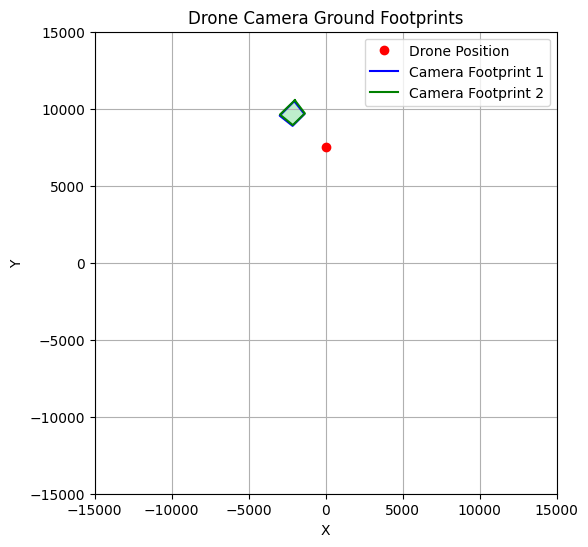

In [6]:
# === Example Simulation of Camera Footprints ===

# Compute ground-intersection corners for the first camera (e.g., takeoff position)
corners_0 = get_ground_corners(x0, y0, h0, theta0, phi0, hfov0)

# Compute ground-intersection corners for the second camera position
corners_1 = get_ground_corners(x1, y1, h1, theta1, phi1, hfov1)

# Print corners for debug/inspection
print(corners_0)

# Visualize the drone position and both camera footprints
plot_drone_view(corners_0, corners_1, (x0, y0))

# === Create Simulated Image Frames ===

# Create an empty black frame (e.g., frame at time t0)
image0 = np.zeros((image_height, image_width), dtype=np.uint8)

# Generate a synthetic frame (e.g., at time t1) with clustered fire-like patterns
image1 = create_synthetic_image_with_clusters(
    image_height=720,
    image_width=1280,
    background_range=(3, 7),  # Simulate a low-intensity background
    cluster_value=200,        # Peak intensity for simulated "fire" clusters
    num_clusters_range=(1, 4),
    cluster_radius_range=(np.round(fire_length_pixel/6), np.round(fire_length_pixel/2))
)

# Add uniformly noisy spots to simulate false detections or thermal clutter
add_uniform_spots(
    image1,
    value_range=(50, 100),  # Intensity range for noise spots
    spot_radius_range=(np.round(fire_length_pixel/2), fire_length_pixel*4),
    num_spots_range=(2, 5)
)

phi=0.0, theta=270.0
phi=8.5, theta=270.0
phi=8.5, theta=360.0
phi=8.5, theta=450.0
phi=8.5, theta=540.0
phi=16.0, theta=270.0
phi=16.0, theta=321.42857142857144
phi=16.0, theta=372.8571428571429
phi=16.0, theta=424.2857142857143
phi=16.0, theta=475.7142857142857


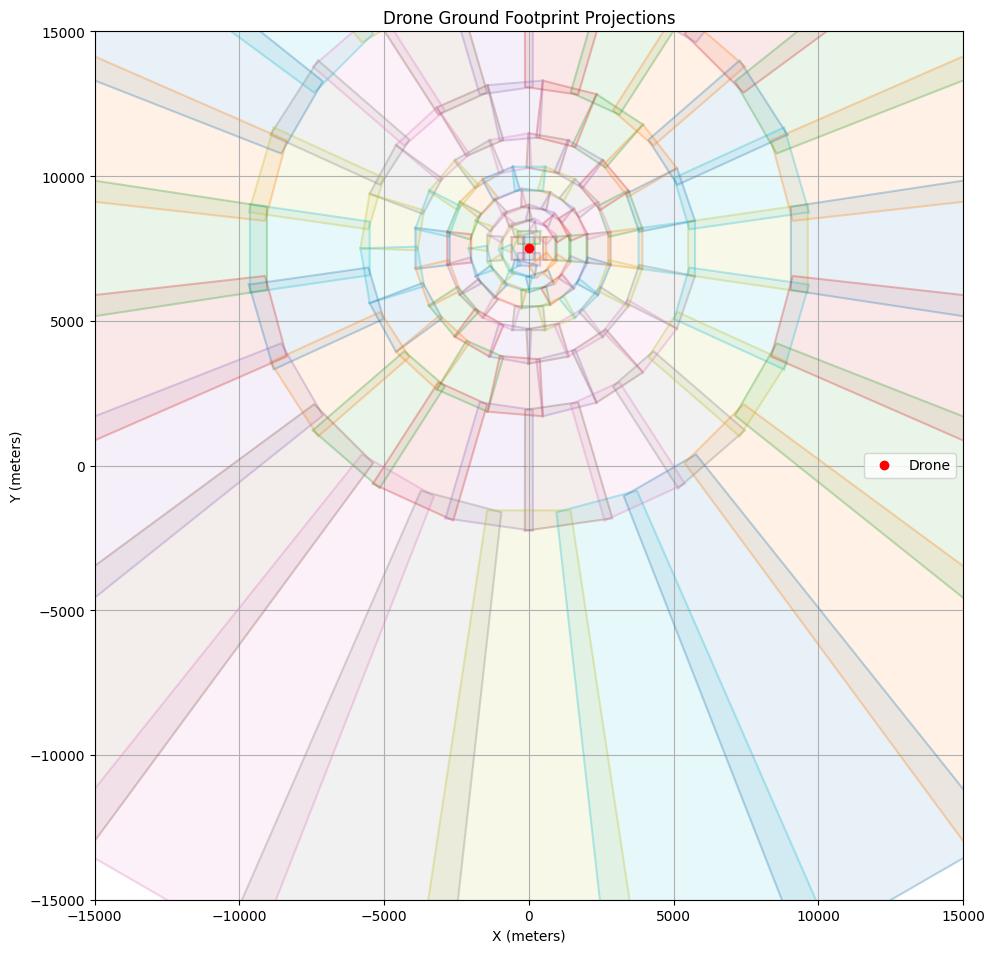

In [7]:
# === Generate PHI and THETA Samples for Camera Orientation Sweep ===

# Define pitch angles (PHI) and number of camera orientations (repetitions) at each pitch
phi_values = [0, 8.5, 16, 25, 34, 43.5, 52.5, 61.5, 70.5, 79.5]
repetitions = [1, 4, 7, 10, 13, 16, 18, 19, 22, 24]

# Initialize lists for pitch (PHI) and yaw (THETA)
PHI = []
THETA = []

# Generate full list of (PHI, THETA) orientations
for phi, reps in zip(phi_values, repetitions):
    PHI.extend([phi] * reps)  # Repeat phi value
    step = 360 / reps        # Angular step between yaw angles at this pitch
    theta_values = [270 + step * i for i in range(reps)] # Start from 270°, evenly spaced
    THETA.extend(theta_values)

# Optionally convert lists to NumPy arrays for later use
PHI = np.array(PHI)
THETA = np.array(THETA)

# Print first few pairs to verify correctness
for p, t in zip(PHI[:10], THETA[:10]):
    print(f"phi={p}, theta={t}")

# === Visualize All Projected Ground Footprints ===

# Initialize plot for ground projection coverage
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.set_title("Drone Ground Footprint Projections")
ax.grid(True)

# Set plot limits
range_xy = 15000
ax.set_xlim(-range_xy, range_xy)
ax.set_ylim(-range_xy, range_xy)

# Loop over all (PHI, THETA) combinations and draw projected camera footprints
for Phi, Theta in zip(PHI, THETA):
    corners = get_ground_corners(x1, y1, h1, Theta, Phi, hfov1)
    polygon = np.vstack([corners, corners[0]])  # Close polygon
    ax.plot(polygon[:, 0], polygon[:, 1], alpha=0.3)       # Outline
    ax.fill(polygon[:, 0], polygon[:, 1], alpha=0.1)       # Fill

# Mark the drone's location
ax.plot(x1, y1, 'ro', label="Drone")

ax.legend()
plt.tight_layout()
plt.show()

## Homography

In [8]:
# === Compute Homography-Based Projection of image0 onto image1's Frame ===

# Step 1: Define the image corners in pixel coordinates for image1
# Format: [top-left, top-right, bottom-right, bottom-left]
pts_image = np.array([
      [0, 0],                                # top-left
      [image_width - 1, 0],                  # top-right
      [image_width - 1, image_height - 1],   # bottom-right
      [0, image_height - 1]                  # bottom-left
  ], dtype=np.float32)

# Step 2: Compute homography that maps world coordinates (corners_1) to image1 pixels
H_world_to_image1 = create_homography(pts_image, corners_1)

# Step 3: Project the world-space corners of image0 (corners_0) into image1's pixel space
pixels_img0_at_img1 = project_points_with_homography(corners_0, H_world_to_image1)

# Step 4: Estimate a homography that maps image1 pixel coordinates to projected image0 corners
H_image1_to_image0 = create_homography(pts_image, pixels_img0_at_img1)

# Step 5: Warp image0 into the pixel frame of image1 using the computed homography
Image0_projected = cv2.warpPerspective(
    image0,                        # source image to warp
    H_image1_to_image0,            # transformation from image1 pixels to image0 projection
    (image1.shape[1], image1.shape[0]),  # output size (same as image1)
    cv2.INTER_LINEAR,              # interpolation method
    borderMode=cv2.BORDER_CONSTANT,           # fill borders with constant value
    borderValue=np.median(image0)             # use median of image0 for padding
)

## Diff Map

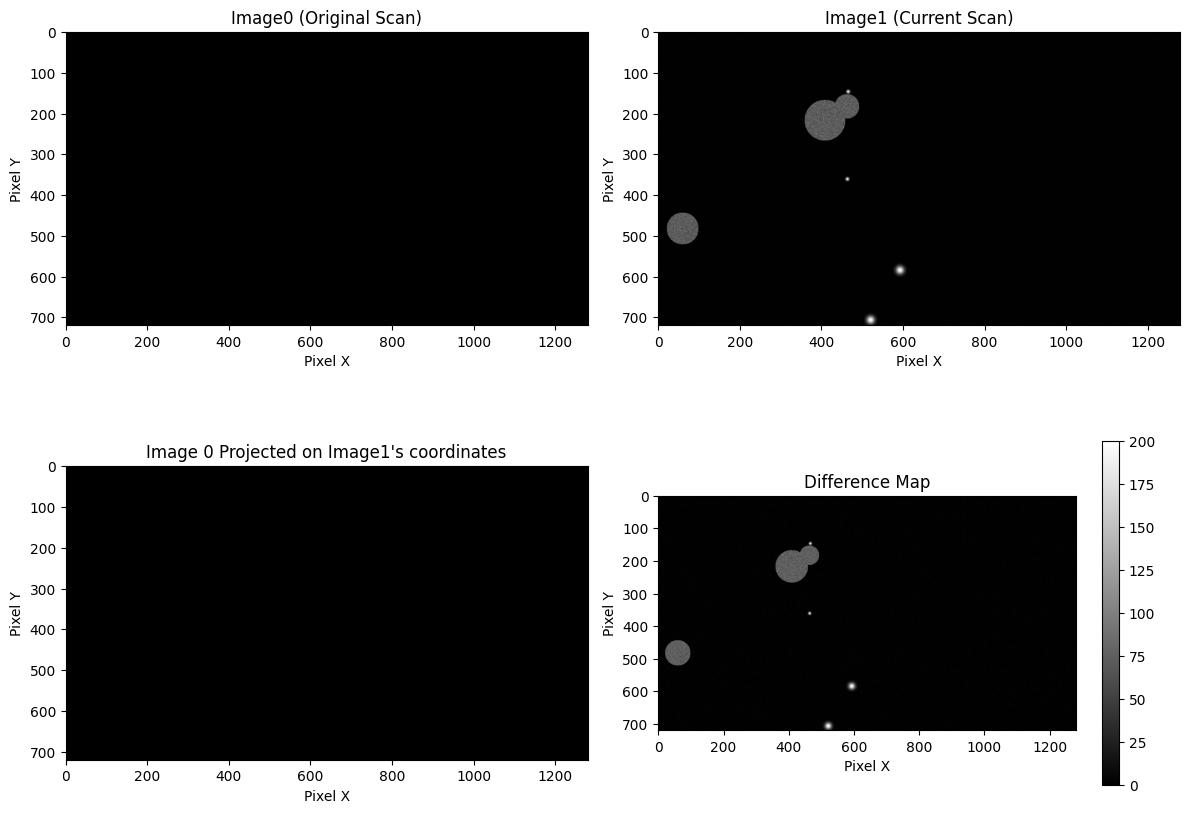

In [9]:
# === Preprocess and Compute Difference ===

# Step 1: Preprocess images (convert to uint8, optionally normalize)
image0, Image0_projected = preprocess_images(image0, Image0_projected, applying=0)

# Step 2: Compute positive difference (changes in image1 that are brighter than image0 projection)
diff_map = compute_positive_difference(Image0_projected, image1)

# Step 3: Post-process the difference map to suppress noise and irrelevant areas
# threshold = 0 keeps only strictly positive differences
# temp_threshold = 0 filters out low-intensity regions in image1
diff_map = postprocess_difference_map(diff_map, image1, threshold=0, temp_threshold=0)

# === Visualization of Image Alignment and Change Detection ===

# Create a 2x2 plot grid for input images and results
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# Top-left: Original baseline image
axs[0, 0].imshow(image0, cmap='gray')
axs[0, 0].set_title("Image0 (Original Scan)")
axs[0, 0].set_xlabel("Pixel X")
axs[0, 0].set_ylabel("Pixel Y")

# Top-right: Current image
axs[0, 1].imshow(image1, cmap='gray')
axs[0, 1].set_title("Image1 (Current Scan)")
axs[0, 1].set_xlabel("Pixel X")
axs[0, 1].set_ylabel("Pixel Y")

# Bottom-left: image0 warped into image1's coordinate system
axs[1, 0].imshow(Image0_projected, cmap='gray')
axs[1, 0].set_title("Image 0 Projected on Image1's coordinates")
axs[1, 0].set_xlabel("Pixel X")
axs[1, 0].set_ylabel("Pixel Y")

# Bottom-right: Final difference map showing significant positive changes
im = axs[1, 1].imshow(diff_map, cmap='gray', vmin=0, vmax=np.max(diff_map))
axs[1, 1].set_title("Difference Map")
axs[1, 1].set_xlabel("Pixel X")
axs[1, 1].set_ylabel("Pixel Y")

# Add colorbar for the difference map
fig.colorbar(im, ax=axs[1, 1], shrink=0.8)

# Improve layout
plt.tight_layout()
plt.show()

## DB_Scan

Detected centers:
Center at (y=148.0, x=466.0)
Center at (y=362.0, x=464.0)
Center at (y=483.0, x=60.0)
Center at (y=585.0, x=593.0)
Center at (y=707.0, x=521.0)


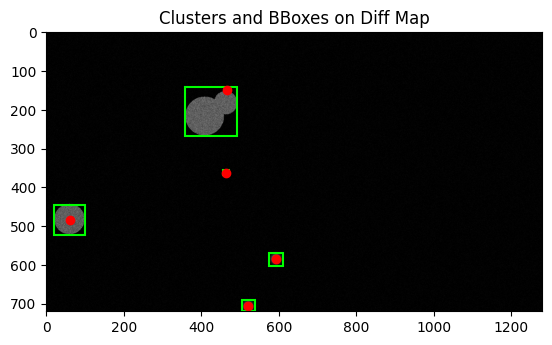

In [10]:
# === Cluster Detection Based on Difference Map ===

# Step 1: Compute DBSCAN parameters based on estimated fire characteristics
min_samples = int(np.ceil(fire_num_pixel / min_samples_factor))
eps_distance = int(np.floor(fire_length_pixel * eps_distance_factor))

# Step 2: Run conditional DBSCAN clustering to identify potential fire regions
centers, label_map, bboxes = find_cluster_centers_conditional(
    diff_map=diff_map,
    threshold=10,           # Only consider pixels with diff > 10
    eps=eps_distance,       # Clustering radius
    min_samples=min_samples,  # Minimum number of points in cluster
    min_contrast=10         # Contrast-based center selection
)

# Step 3: Print the detected cluster centers
print("Detected centers:")
for c in centers:
    print(f"Center at (y={c[0]:.1f}, x={c[1]:.1f})")

# === Visualize Clusters and Bounding Boxes ===

plt.imshow(diff_map, cmap='gray')

# Overlay red markers at detected cluster centers
for y, x in centers:
    plt.plot(x, y, 'ro')

# Overlay bounding boxes around detected clusters
for min_y, min_x, max_y, max_x in bboxes:
    width = max_x - min_x
    height = max_y - min_y
    rect = patches.Rectangle(
        (min_x, min_y),
        width,
        height,
        linewidth=1.5,
        edgecolor='lime',
        facecolor='none'
    )
    plt.gca().add_patch(rect)

plt.title("Clusters and BBoxes on Diff Map")
plt.show()


## Requiered FOV

In [11]:
# === Compute Required FOVs Based on Detected Cluster Bounding Boxes ===

# Estimate the desired fire size in RGB pixel scale (target size for zoom decision)
pixels_RGB_at_patch = patch_length * ratio_patch  # target fire size in RGB pixels

# Initialize lists to store computed FOVs per bounding box
required_fov1 = []  # FOVs based on patch resolution requirement
required_fov2 = []  # FOVs based on entire image resolution requirement

# Loop through each detected bounding box
for bbox in bboxes:
    x_min, y_min, x_max, y_max = bbox

    # Compute width and height of the bounding box in IR pixel coordinates
    width = x_max - x_min
    height = y_max - y_min

    # Take the longer dimension as the dominant fire size
    pixels_IR_at_current = max(width, height)

    # Convert fire size from IR pixels to RGB pixels
    pixels_RGB_at_current = pixels_IR_at_current * IR2RGB_ratio


    # --- FOV Type 1: Based on patch resolution ---
    # Required FOV that would map the target patch size to the current pixel size
    fov = HFOV / (ratio_patch * patch_length / pixels_RGB_at_current)
    fov_clipped = np.clip(fov, min_fov, max_fov)
    required_fov1.append(fov_clipped)

    # --- FOV Type 2: Based on whole image resolution requirement ---
    fov2 = HFOV / (ratio_image * rgb_len / pixels_RGB_at_current)
    fov_clipped2 = np.clip(fov2, min_fov, max_fov)
    required_fov2.append(fov_clipped2)

# Output the results for each strategy
print("Detected fov1:")
for c in required_fov1:
    print(f"Required FOV = {c}")

print("Detected fov2:")
for c in required_fov2:
    print(f"Required FOV = {c}")

Detected fov1:
Required FOV = 22.44408378250429
Required FOV = 2.3449042757840304
Required FOV = 13.064466679368168
Required FOV = 5.694767526904074
Required FOV = 5.694767526904074
Detected fov2:
Required FOV = 13.034193841098785
Required FOV = 2.2
Required FOV = 7.587068056758996
Required FOV = 3.307183511920588
Required FOV = 3.307183511920588


## Simulating Zoom Preview (Phase 2)

patch length:
patch length = 386.0
patch length = 239.0
patch length = 386.0
patch length = 386.0
patch length = 386.0


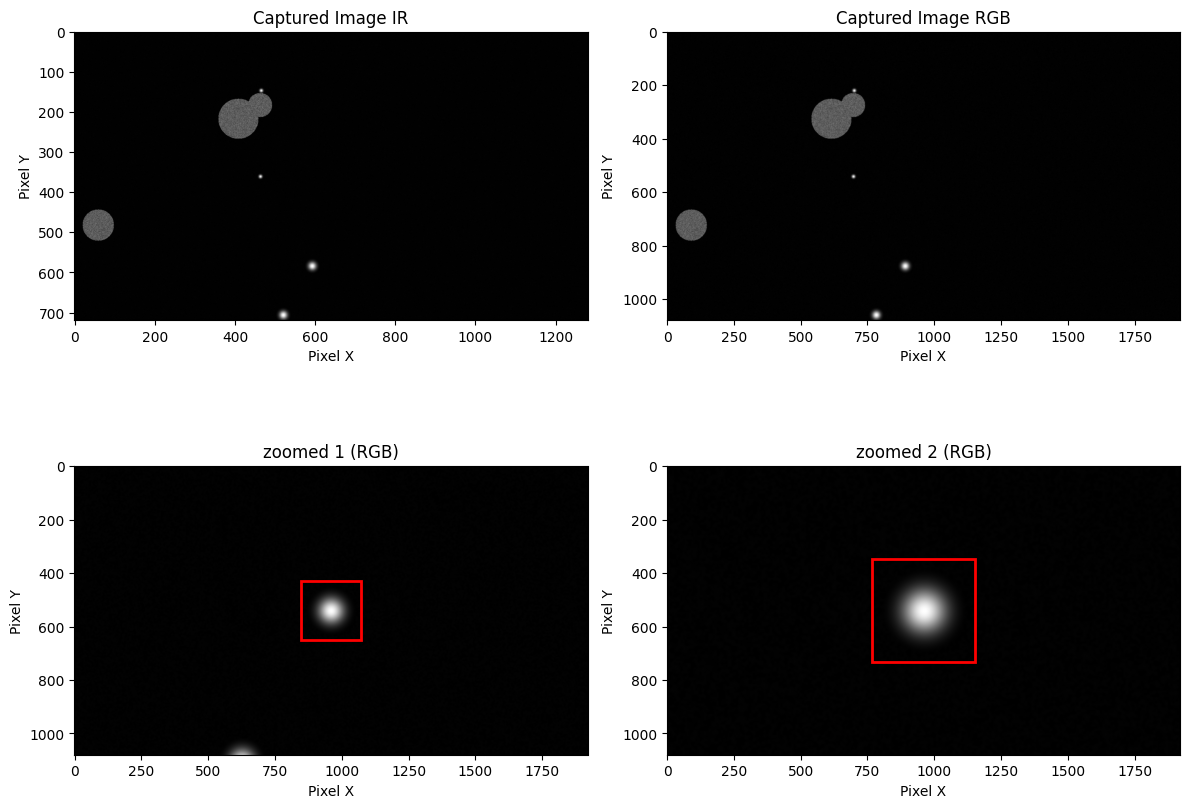

In [12]:
# === Simulate Zoom Based on Required FOV1 ===

center_num = 3  # Select cluster index to zoom on

# Resize the original IR image to RGB resolution for simulation
imge1_rgb = cv2.resize(image1, (1920, 1080), interpolation=cv2.INTER_LINEAR)

# Compute FOV ratio based on required_fov1
fov_ratio = required_fov1[center_num] / hfov1

# Simulate zoomed image centered at the selected detection
cropped, zoomed = simulate_zoom(imge1_rgb, centers[center_num], fov_ratio)

# Define bounding box coordinates (centered patch at zoomed resolution)
center_box = (zoomed.shape[1] // 2, zoomed.shape[0] // 2)  # center in zoomed image
top_left_x = center_box[0] - patch_length // 2
top_left_y = center_box[1] - patch_length // 2

# === Simulate Zoom Based on Required FOV2 and Adjusted Patch Sizes ===

patch_lengths = []  # Will store per-detection patch sizes

i = 0

for bbox in bboxes:
    x_min, y_min, x_max, y_max = bbox

    # Compute width and height of bounding box in IR space
    width = x_max - x_min
    height = y_max - y_min

    # Convert dominant side of cluster to RGB pixel units
    pixels_IR_at_current = max(width, height)
    pixels_RGB_at_current = pixels_IR_at_current * IR2RGB_ratio

    # Compute corresponding patch size based on required_fov2
    patch_length2 = (HFOV/required_fov2[i]) * (pixels_RGB_at_current / ratio_patch)
    patch_lengths.append(np.round(patch_length2))
    i += 1

# Output estimated patch sizes
print("patch length:")
for c in patch_lengths:
    print(f"patch length = {c}")

# Simulate zoom for required_fov2
imge1_rgb2 = cv2.resize(image1, (1920, 1080), interpolation=cv2.INTER_LINEAR)
fov_ratio2 = required_fov2[center_num] / hfov1
cropped2, zoomed2 = simulate_zoom(imge1_rgb2, centers[center_num], fov_ratio2)

# Define patch center and top-left coordinates
center_box2 = (zoomed2.shape[1] // 2, zoomed2.shape[0] // 2)  # center in zoomed image
top_left_x2 = center_box2[0] - patch_lengths[center_num] // 2
top_left_y2 = center_box2[1] - patch_lengths[center_num] // 2


# === Visualization of Zoom Results ===

fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# Top-left: Original IR image
axs[0, 0].imshow(image1, cmap='gray')
axs[0, 0].set_title("Captured Image IR")
axs[0, 0].set_xlabel("Pixel X")
axs[0, 0].set_ylabel("Pixel Y")

# Top-right: Upsampled RGB simulation (before zoom)
axs[0, 1].imshow(imge1_rgb, cmap='gray')
axs[0, 1].set_title("Captured Image RGB")
axs[0, 1].set_xlabel("Pixel X")
axs[0, 1].set_ylabel("Pixel Y")

# Bottom-left: Zoomed result using FOV1 strategy
axs[1, 0].imshow(zoomed, cmap='gray')
axs[1, 0].set_title("zoomed 1 (RGB)")
axs[1, 0].set_xlabel("Pixel X")
axs[1, 0].set_ylabel("Pixel Y")

# Draw patch box on zoomed1
bbox_rect = patches.Rectangle(
    (top_left_x, top_left_y),
    patch_length,
    patch_length,
    linewidth=2,
    edgecolor='r',
    facecolor='none'
)
axs[1, 0].add_patch(bbox_rect)


# Bottom-right: Zoomed result using FOV2 strategy
im = axs[1, 1].imshow(zoomed2, cmap='gray')
axs[1, 1].set_title("zoomed 2 (RGB)")
axs[1, 1].set_xlabel("Pixel X")
axs[1, 1].set_ylabel("Pixel Y")

# Draw patch box on zoomed2
bbox_rect = patches.Rectangle(
    (top_left_x2, top_left_y2),
    patch_lengths[center_num],
    patch_lengths[center_num],
    linewidth=2,
    edgecolor='r',
    facecolor='none'
)
axs[1, 1].add_patch(bbox_rect)


# Final layout adjustment
plt.tight_layout()
plt.show()